# Run NNCME with a Gene Expression Example

This is a simple sample of implementing a gene expression example with NNCME. \
Follow this notebook, you can conveniently use the VAN to gain a gene expression system data which contains the joint distribution between species.\
Refer to `Detailed Version of Gene Expression.ipynb` and `Toggle Switch Example.ipynb` for more detailed guidance.

## 1. Implement the code
Run MasterEq.py to calculate the gene expression example. After this step, you can get the system data `SampleSum` by the VAN, which contains the joint distribution information between species.  (the data `Data.npz` will also be saved in the `out` folder)\
Adjust the hyperparameters if you need. The accuracy can be improved by increasing `args.batch_size` and `args.max_stepLater`.

In [ ]:
###MasterEq.py
from args import args
import numpy as np
from main import Test
from main2 import Test2

###Add models----------------------------------
from ToggleSwitch import ToggleSwitch
from EarlyLife import EarlyLife
from Epidemic import Epidemic
from cascade1 import cascade1
from cascade1_inverse import cascade1_inverse
from cascade2 import cascade2
from cascade3 import cascade3
from BirthDeath import BirthDeath
from GeneExp import GeneExp
from AFL import AFL

##Set parameters-------------------------------
###Initialize parameters: otherwise the parameters are specified in init_out_dir-> args.py
args.Model='GeneExp' #Model name
args.L=2 #Species number
args.M=int(100) #Upper limit of the molecule number
args.batch_size=100 #Number of batch samples
args.Tstep=1001# Time step of iterating the chemical master equation
args.delta_t=0.05 #Time step length

args.net ='rnn'
args.max_stepAll=2000 #Maximum number of steps first time step
args.max_stepLater=10 #Maximum number of steps of later time steps
args.net_depth=1 # including output layer and not input data layer
args.net_width=32
args.print_step=50 # To save data every print_step
args.lr=0.001
args.binary=False
args.AdaptiveT=False
args.AdaptiveTFold=5

args.saving_data_time_step=[0,1e2,5e2,2e3,1e4,2e4,5e4,1e5,1.5e5,2e5,2.5e5,3e5,3.5e5,4e5,5e5,6e5,7e5,8e5,9e5,1e6] #To save data at which time steps (give in a list)
args.training_loss_print_step=[0,1,2,101,1001,2e3,1e4,1e5,2e5,3e5,4e5,5e5] #To print training loss at which time steps (give in a list)

###Default parameters:
args.bias=True
args.bits=1
if args.binary:
    args.bits=int(np.ceil(np.log2(args.M)))
args.Percent=0.2         
args.clip_grad=1
args.dtype='float64'
args.epsilon=1e-30#initial probability of zero species number
args.lr_schedule=False#True

print(vars()[args.Model])
model = vars()[args.Model](**vars(args)) 

#Run model-----------------------------------------        
if __name__ == '__main__':
    Loss, SampleSum = Test(model)
    # Loss: the converged KL-divergence at the final epoch for every save time step
    # SampleSum: the samples generated from the joint probability (size: SaveTimeStep × SampleNum × SpeciesNum)
    # The save time steps depend on args.Tstep / args.print_step
    
#     SampleSum.shape (5001, 1000, 2)
#     Time(min)  9.22015440861384
#     Time(hr)  0.153669240143564

# SampleSum.shape (21, 1000, 2)
# Time(min)  2.101927626132965
# Time(hr)  0.035032127102216086

## 2.  Run Gillespie simulation
To evaluate the accuracy of the learnt distribution by the VAN, we can compare the resultant marginal distribution of one species with those from Gillespie algorithm. The following program implements using the Gillespie algorithm to calculate the gene expression system. The key parameters, such as algorithm simulation time `T` and algorithm simulation times `times`, can be modified as needed.

In [47]:
import numpy as np
import biocircuits
import matplotlib.pyplot as plt
import time

def GeneExp_propensity(
    propensities, population, t, kr, kp, yr, yp
):
    #species
    r, p = population
    propensities[0] = kr
    propensities[1] = kp*r
    propensities[2] = yr*r
    propensities[3] = yp*p

#the stoichiometric matrix       
GeneExp_update = np.array(
    [
        [ 1, 0 ], 
        [ 0, 1 ],
        [-1, 0 ],
        [ 0,-1 ], 
    ],dtype=int)

#the reaction rates 
kr = 0.1 #kr
kp = 0.1 #kp
yr = 0.1 #yr
yp = 0.002 #yp 

GeneExp_args = (kr, kp, yr, yp)

#initial number of species 
r0=0
p0=0
GeneExp_pop_0 = np.array([r0,p0], dtype=float) # follow VAN's learnt initial number

#simulation time length
T=50
time_points = np.linspace(0, T, 50)

Run=1 #run Gillespie or not
times=1000 #Gillespie simulation times

out_filename = 'GeneExp_times'+str(times)+'_T'+str(T)+'_dis'+str(r0)+'_'+str(p0) #filename to save

if Run==1:
    startT=time.time()
    r_total=np.empty(shape=(0,len(time_points)))#to save the time evolution of mRNA number in each simulation (dimension: times*time_points)
    p_total=np.empty(shape=(0,len(time_points)))#to save the time evolution of protein number in each simulation (dimension: times*time_points)
    
    for i in range(times):
        
        # Perform the Gillespie simulation
        pop = biocircuits.gillespie_ssa(
            GeneExp_propensity,
            GeneExp_update,
            GeneExp_pop_0,
            time_points,
            args=GeneExp_args,
        )
        
        r_total=np.row_stack((r_total,pop[0,:,0]))
        p_total=np.row_stack((p_total,pop[0,:,1]))
        
    np.savez('{}'.format(out_filename),np.array(times),np.array(time_points),r_total,p_total) #sava data
    endT=time.time()
    print('Time(min)',(endT-startT)/60)
else: #load existing data file
    data=np.load(out_filename+'.npz')
    print(list(data))    
    time_points = data['arr_1']
    r_total = data['arr_2']
    p_total = data['arr_3']
    
# Time(min) 1.1289569854736328

Time(min) 1.1289569854736328


## 3. Plot Results
Plot the result of the gene expression. Relevant details can be referred in the Supplement Information of the manuscript.
The following code plots the average number of species over time obtained by two methods. Please refer to `Detailed Version of Gene Expression.ipynb` for more plotting codes. 

<Figure size 2400x1600 with 0 Axes>

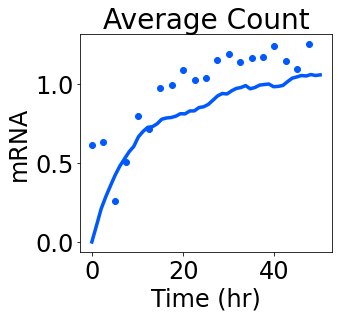

<Figure size 2400x1600 with 0 Axes>

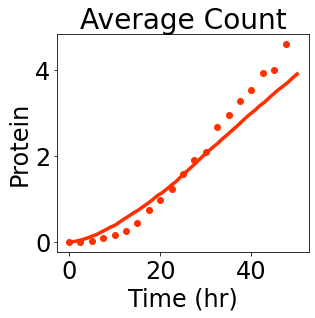

In [49]:
# load data of the VAN and Gillespie
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

jet = cm.get_cmap('jet')
jet_12_colors = jet(np.linspace(0, 1, 15))
plt.rc('font', size=24)

# path1="GeneExpression\GeneExp1_times10000_T3600_dis0_0.npz" # Gillespie data path
# path2="GeneExpression\Data_GeneExp1_M100_T36001_dt0.1_batch1000.npz" # VAN data path

# data1=np.load(path1)
# times = data1['arr_0']
# time_points = data1['arr_1']
tfinal = time_points[-1]
step = time_points[1]-time_points[0]

rna_total = r_total#data1['arr_2']
prot_total = p_total#data1['arr_3']
    
rna_total_mean=np.mean(rna_total,0)
rna_total_std=np.std(rna_total,0)
prot_total_mean=np.mean(prot_total,0)
prot_total_std=np.std(prot_total,0)

# data2=np.load(path2, allow_pickle=True)
# argsSave = data2['arr_1']
delta_t=args.delta_t#argsSave[1]
print_step= args.print_step#argsSave[7]
Tstep=args.Tstep
SampleSum=SampleSum#data2['arr_5']
TimePoins=np.arange(0,args.Tstep,print_step)*delta_t

# The time evolution of the average counts for the genes and proteins,  from the VAN (dots) and the Gillespie simulation (lines). 
#####curve-----------------------------------

markersize0=6
step=max(1,int(len(TimePoins)/25))

plt.figure(num=None,  dpi=400, edgecolor='k')
fig, axes = plt.subplots(1,1)
plt.plot(time_points,rna_total_mean,linewidth=3.5,color=jet_12_colors[3,:])
plt.plot(TimePoins[0:-1:step],np.mean(SampleSum[:,:,0],axis=1)[0:-1:step],
          marker='o',linestyle = 'None',color=jet_12_colors[3,:],markersize=markersize0)
plt.xlabel("Time (hr)")
plt.ylabel("mRNA")
fig.set_size_inches(4.5, 4)
plt.title('Average Count',fontsize=28)
# plt.savefig('GE_panela1.svg', bbox_inches="tight", dpi=400)

plt.figure(num=None,  dpi=400, edgecolor='k')
fig, axes = plt.subplots(1,1)
plt.plot(time_points,prot_total_mean,linewidth=3.5,color=jet_12_colors[12,:])
plt.plot(TimePoins[0:-1:step],np.mean(SampleSum[:,:,1],axis=1)[0:-1:step],
          marker='o',linestyle = 'None',color=jet_12_colors[12,:],markersize=markersize0)
plt.xlabel("Time (hr)")
plt.ylabel("Protein")
plt.title('Average Count',fontsize=28)
fig.set_size_inches(4.5, 4)
# plt.savefig('GE_panela2.svg', bbox_inches="tight", dpi=400)